In [1]:
from scipy import ndimage as ndi
from skimage import feature
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import pandas as pd
import sys
sys.path.append("../")
import gyrochrones as gyr
from scipy import signal
from gradkde import kde
from gradkde import kernels

red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'

pl.rc('xtick', labelsize=20)
pl.rc('ytick', labelsize=20)
pl.rc('axes', labelsize=25)
pl.rc('axes', titlesize=30)
pl.rc('legend', handlelength=1)
pl.rc('legend', fontsize=20)

%matplotlib inline

In [2]:
df = pd.read_hdf('../output/good.h5')
x = df['bp_rp']
dx = np.sqrt((1/df['phot_bp_mean_flux_error'])**2 + 
             (1/df['phot_rp_mean_flux_error'])**2)
y = df['logperiod_mean']
dy = df['logperiod_sd']

data = np.vstack((x, y)).T

In [506]:
gauss = kernels.Gaussian()
kde1 = kde.KDE(gauss, 0.05, nderiv=0)
kde2 = kde.KDE(gauss, 0.05, nderiv=1)
kde3 = kde.KDE(gauss, 0.08, nderiv=3)

kde1.condition(data)
kde2.condition(data)
kde3.condition(data)

gridx = np.linspace(x.min(), x.max(), 800)
gridy = np.linspace(y.min(), y.max(), 800)
grid = np.meshgrid(gridx, gridy)
points = np.concatenate(np.array(grid).T)

z1 = kde1.evaluate_on_grid(grid)
z2 = kde2.evaluate_on_grid(grid, separate_vectors=True)
z3 = kde3.evaluate_on_grid(grid, separate_vectors=True)

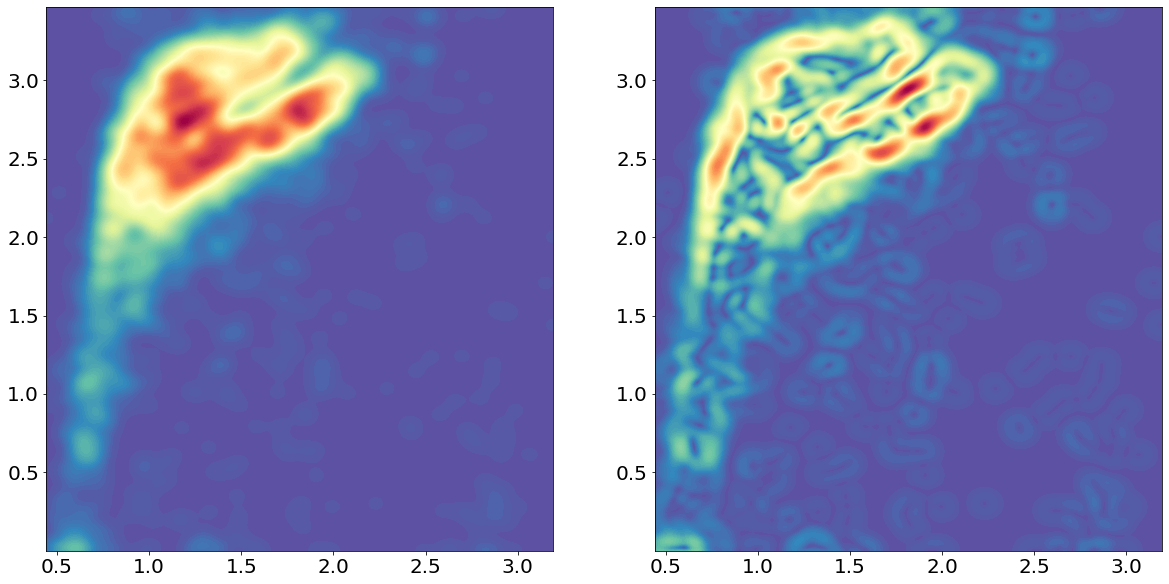

In [507]:
fig, ax = pl.subplots(1, 2, figsize=(20, 10))
ax[0].contourf(gridx, gridy, z1.T, 100, cmap='Spectral_r')
ax[1].contourf(gridx, gridy, np.linalg.norm(z2, axis=0).T, 100, cmap='Spectral_r')

In [508]:
from scipy.ndimage import generate_binary_structure, binary_erosion, label

def detect_edges(z):

    gradx = z[0]
    grady = z[1]
    magnitude = np.linalg.norm(z, axis=0)
    mask = np.ones(magnitude.shape, dtype=bool)
    s = generate_binary_structure(2, 2)
    eroded_mask = binary_erosion(mask, s, border_value=0)
    eroded_mask = eroded_mask & (magnitude > 0)

    local_maxima = np.zeros(magnitude.shape, bool)
    pts_plus = (gradx >= 0) & (grady >= 0) & (np.abs(gradx) >= np.abs(grady))
    pts_minus = (gradx <= 0) & (grady <= 0) & (np.abs(gradx) >= np.abs(grady))
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts

    c1 = magnitude[1:, :][pts[:-1, :]]
    c2 = magnitude[1:, 1:][pts[:-1, :-1]]
    m = magnitude[pts]
    w = np.abs(grady)[pts] / np.abs(gradx)[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[:-1, :][pts[1:, :]]
    c2 = magnitude[:-1, :-1][pts[1:, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus

    pts_plus = (gradx >= 0) & (grady >= 0) & (np.abs(gradx) <= np.abs(grady))
    pts_minus = (gradx <= 0) & (grady <= 0) & (np.abs(gradx) <= np.abs(grady))
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1 = magnitude[:, 1:][pts[:, :-1]]
    c2 = magnitude[1:, 1:][pts[:-1, :-1]]
    m = magnitude[pts]
    w = np.abs(gradx)[pts] / np.abs(grady)[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[:, :-1][pts[:, 1:]]
    c2 = magnitude[:-1, :-1][pts[1:, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus

    pts_plus = (gradx <= 0) & (grady >= 0) & (np.abs(gradx) <= np.abs(grady))
    pts_minus = (gradx >= 0) & (grady <= 0) & (np.abs(gradx) <= np.abs(grady))
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1a = magnitude[:, 1:][pts[:, :-1]]
    c2a = magnitude[:-1, 1:][pts[1:, :-1]]
    m = magnitude[pts]
    w = np.abs(gradx)[pts] / np.abs(grady)[pts]
    c_plus = c2a * w + c1a * (1.0 - w) <= m
    c1 = magnitude[:, :-1][pts[:, 1:]]
    c2 = magnitude[1:, :-1][pts[:-1, 1:]]
    c_minus = c2 * w + c1 * (1.0 - w) <= m
    local_maxima[pts] = c_plus & c_minus

    pts_plus = (gradx <= 0) & (grady >= 0) & (np.abs(gradx) >= np.abs(grady))
    pts_minus = (gradx >= 0) & (grady <= 0) & (np.abs(gradx) >= np.abs(grady))
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1 = magnitude[:-1, :][pts[1:, :]]
    c2 = magnitude[:-1, 1:][pts[1:, :-1]]
    m = magnitude[pts]
    w = np.abs(grady)[pts] / np.abs(gradx)[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[1:, :][pts[:-1, :]]
    c2 = magnitude[1:, :-1][pts[:-1, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus

    high_threshold = 0.2
    low_threshold = 0.1
    high_mask = local_maxima & (magnitude >= high_threshold)
    low_mask = local_maxima & (magnitude >= low_threshold)

    strel = np.ones((3, 3), bool)
    labels, count = label(low_mask, strel)
    if count == 0:
        return low_mask

    sums = (np.array(ndi.sum(high_mask, labels,
                         np.arange(count, dtype=np.int32) + 1),
                 copy=False, ndmin=1))
    good_label = np.zeros((count + 1,), bool)
    good_label[1:] = sums > 0
    output_mask = good_label[labels]
    return output_mask

In [509]:
edge_mask = detect_edges(z2)

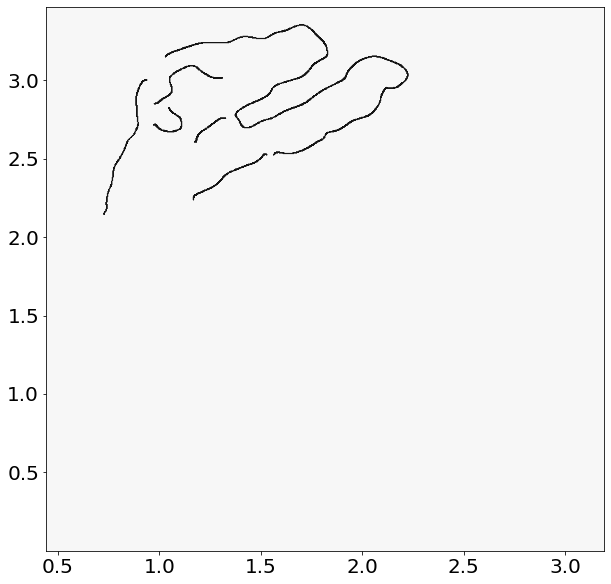

In [510]:
pl.figure(figsize=(10, 10))
pl.contourf(gridx, gridy, edge_mask.T, cmap='Greys')

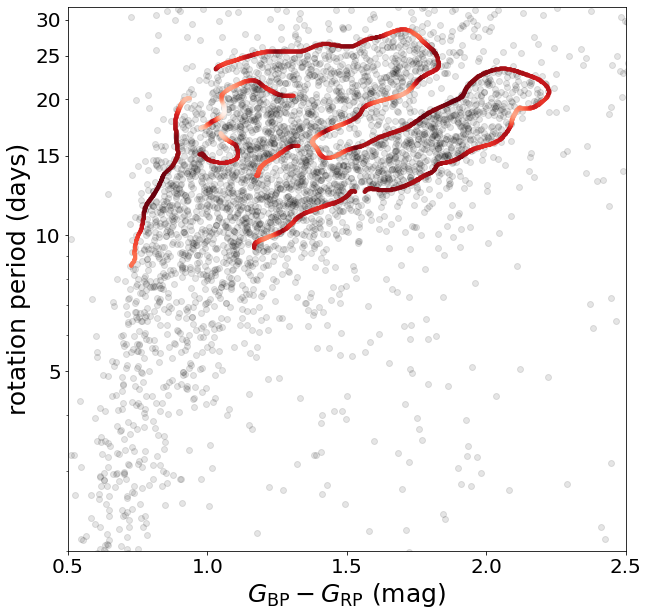

In [511]:
fx = z2[0]
fy = z2[1]
sigx =  np.sign(fx) * (np.sqrt(2 * np.pi) * np.abs(fx)) ** (-1/3)
sigy =  np.sign(fy) * (np.sqrt(2 * np.pi) * np.abs(fy)) ** (-1/3)
sigx = sigx[edge_mask.T]
sigy = sigy[edge_mask.T]

edge_x = grid[0][edge_mask.T]
edge_y = grid[1][edge_mask.T]

mags = np.linalg.norm(z3, axis=0)
mags[edge_mask.T == 0] = np.nan

fig = pl.figure(figsize=(10, 10))
pl.yscale('log')
pl.plot(x, np.exp(y), 'ko', alpha=0.1, zorder=-1)
pl.scatter(edge_x, np.exp(edge_y), c=mags[edge_mask.T], cmap='Reds_r', s=10)
pl.xlabel("$G_\mathrm{BP} - G_\mathrm{RP}$ (mag)")
pl.ylabel("rotation period (days)")
pl.gca().yaxis.set_major_formatter(pl.ScalarFormatter())
pl.gca().set_yticks([1, 5, 10, 15, 20, 25, 30])
pl.gca().set_xticks(np.linspace(0.5, 2.5, 5))
pl.xlim(0.5, 2.5)
pl.ylim(2.0, 32)

pl.savefig('/Users/tgordon/Desktop/edges.pdf')

In [629]:
# make table of edge locations 
gaptrend = np.log(6*(2**edge_x))
gapmask = (edge_y - gaptrend > -0.15) & (edge_y - gaptrend < 0.1)
gapmask = gapmask & (edge_x > 1.45) & (edge_x < 2.0)
lower = (edge_y - gaptrend < 0)
upper = (edge_y - gaptrend > 0)

for bp_rp in [1.45, 1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0]:
    
    up_edge = 0.0
    try:
        i_up = np.where(np.isclose(edge_x[gapmask & upper], bp_rp, atol=0.003))[0][0]
        up_edge = edge_y[gapmask & upper][i_up]
    except:
        pass
    
    low_edge = 0.0
    try:
        i_low = np.where(np.isclose(edge_x[gapmask & lower], bp_rp, atol=0.003))[0][0]
        low_edge = edge_y[gapmask & lower][i_low]
    except:
        pass
    width = up_edge - low_edge
    print("{:0.2f} & {:0.2f} & {:0.2f} & {:0.2f} \\\\".format(edge_x[gapmask & lower][i_low], low_edge, up_edge, width))

1.45 & 2.70 & 2.85 & 0.15 \\
1.50 & 2.74 & 2.88 & 0.14 \\
1.55 & 2.75 & 2.93 & 0.17 \\
1.60 & 2.79 & 2.98 & 0.19 \\
1.65 & 2.82 & 3.00 & 0.18 \\
1.70 & 2.84 & 3.02 & 0.18 \\
1.75 & 2.88 & 3.08 & 0.20 \\
1.80 & 2.93 & 3.13 & 0.20 \\
1.85 & 2.97 & 0.00 & -2.97 \\
1.90 & 3.00 & 0.00 & -3.00 \\
1.95 & 3.08 & 0.00 & -3.08 \\
2.00 & 3.13 & 0.00 & -3.13 \\


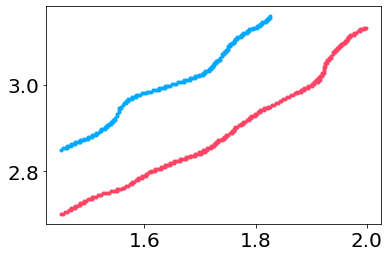

In [630]:
# fit gap edges

pl.plot(edge_x[gapmask & lower], edge_y[gapmask & lower], '.', color=red)
pl.plot(edge_x[gapmask & upper], edge_y[gapmask & upper], '.', color=blue)

In [637]:
from scipy.optimize import curve_fit

def model1(x, x0, a, b):
    return a*(x - x0)**0.5 + b*(x - x0)# + c*(x-x0)**2

def model2(x, x0, a, b, c):
    return a*(x - x0)**0.5 + b*(x - x0) + c*(x-x0)**2



coeffs_lower = curve_fit(model2, edge_x[gapmask & lower], edge_y[gapmask & lower])[0]
coeffs_upper = curve_fit(model1, edge_x[gapmask & upper], edge_y[gapmask & upper])[0]

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


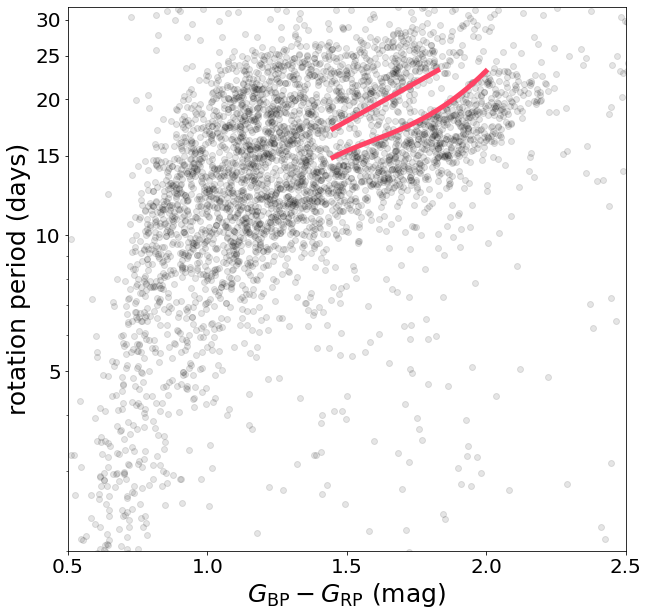

In [647]:
fig = pl.figure(figsize=(10, 10))
pl.yscale('log')
pl.plot(x, np.exp(y), 'ko', alpha=0.1, zorder=-1)
#pl.scatter(edge_x, np.exp(edge_y), c=mags[edge_mask.T], cmap='Reds_r', s=10)
pl.xlabel("$G_\mathrm{BP} - G_\mathrm{RP}$ (mag)")
pl.ylabel("rotation period (days)")
pl.gca().yaxis.set_major_formatter(pl.ScalarFormatter())
pl.gca().set_yticks([1, 5, 10, 15, 20, 25, 30])
pl.gca().set_xticks(np.linspace(0.5, 2.5, 5))
pl.xlim(0.5, 2.5)
pl.ylim(2.0, 32)

#pl.plot(edge_x, edge_y, '.', color=red)
pl.plot(edge_x[gapmask & lower], np.exp(model2(edge_x[gapmask & lower], *coeffs_lower)), 
        color=red, linewidth=5)

#pl.plot(edge_x[gapmask & upper], edge_y[gapmask & upper], '.', color=blue)
pl.plot(edge_x[gapmask & upper], np.exp(model1(edge_x[gapmask & upper], *coeffs_upper)), 
        color=red, linewidth=5)
pl.savefig('/Users/tgordon/Desktop/fit.pdf')

In [648]:
coeffs_upper

array([-5.97412117, -2.20488199,  1.19250122,  1.        ])